In [1]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


## Impoting necessary libraries

In [2]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music.
# It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, LSTM, Reshape
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Importing dataset

In [3]:
Ravdess = "/content/drive/MyDrive/SpeechEmotionRecognition/ravdess/"
Crema = "/content/drive/MyDrive/SpeechEmotionRecognition/CREMA-D/"
Tess = "/content/drive/MyDrive/SpeechEmotionRecognition/TESS/"
Savee = "/content/drive/MyDrive/SpeechEmotionRecognition/SAVEE/"

In [4]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

<ipython-input-4-9455e7d8fd7d>:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)


Emotions                                               Path
0     calm  /content/drive/MyDrive/SpeechEmotionRecognitio...
1     calm  /content/drive/MyDrive/SpeechEmotionRecognitio...
2     calm  /content/drive/MyDrive/SpeechEmotionRecognitio...
3  neutral  /content/drive/MyDrive/SpeechEmotionRecognitio...
4  neutral  /content/drive/MyDrive/SpeechEmotionRecognitio...

In [5]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                               Path
0  neutral  /content/drive/MyDrive/SpeechEmotionRecognitio...
1    happy  /content/drive/MyDrive/SpeechEmotionRecognitio...
2  neutral  /content/drive/MyDrive/SpeechEmotionRecognitio...
3    angry  /content/drive/MyDrive/SpeechEmotionRecognitio...
4    angry  /content/drive/MyDrive/SpeechEmotionRecognitio...

In [6]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

Emotions                                               Path
0  surprise  /content/drive/MyDrive/SpeechEmotionRecognitio...
1  surprise  /content/drive/MyDrive/SpeechEmotionRecognitio...
2  surprise  /content/drive/MyDrive/SpeechEmotionRecognitio...
3  surprise  /content/drive/MyDrive/SpeechEmotionRecognitio...
4  surprise  /content/drive/MyDrive/SpeechEmotionRecognitio...

In [7]:
Tess_df['Emotions'].value_counts()

Emotions
surprise     400
neutral      400
sad          400
happy        400
disgust      400
fear         400
angry        400
happy (1)     10
Name: count, dtype: int64

In [8]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions                                               Path
0    angry  /content/drive/MyDrive/SpeechEmotionRecognitio...
1    angry  /content/drive/MyDrive/SpeechEmotionRecognitio...
2    angry  /content/drive/MyDrive/SpeechEmotionRecognitio...
3    angry  /content/drive/MyDrive/SpeechEmotionRecognitio...
4  disgust  /content/drive/MyDrive/SpeechEmotionRecognitio...

In [9]:
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)

data_path.head(100)

Emotions                                               Path
0      calm  /content/drive/MyDrive/SpeechEmotionRecognitio...
1      calm  /content/drive/MyDrive/SpeechEmotionRecognitio...
2      calm  /content/drive/MyDrive/SpeechEmotionRecognitio...
3   neutral  /content/drive/MyDrive/SpeechEmotionRecognitio...
4   neutral  /content/drive/MyDrive/SpeechEmotionRecognitio...
..      ...                                                ...
95     fear  /content/drive/MyDrive/SpeechEmotionRecognitio...
96     fear  /content/drive/MyDrive/SpeechEmotionRecognitio...
97  disgust  /content/drive/MyDrive/SpeechEmotionRecognitio...
98  disgust  /content/drive/MyDrive/SpeechEmotionRecognitio...
99    angry  /content/drive/MyDrive/SpeechEmotionRecognitio...

[100 rows x 2 columns]

# Data Visualisation and Exploration



In [10]:
data_path = data_path[data_path['Emotions'] != 'happy (1)'];

In [11]:
data_path['Emotions'].unique()

array(['calm', 'neutral', 'happy', 'sad', 'angry', 'fear', 'surprise',
       'disgust'], dtype=object)

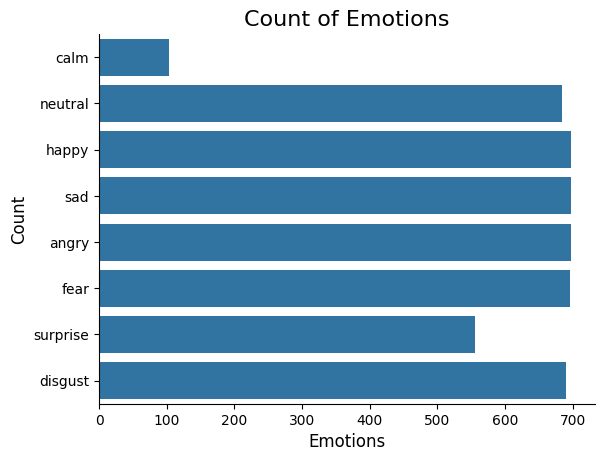

In [12]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [13]:
data_path['Emotions'].value_counts()

Emotions
angry       698
happy       697
sad         697
fear        696
disgust     690
neutral     684
surprise    556
calm        104
Name: count, dtype: int64

In [14]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

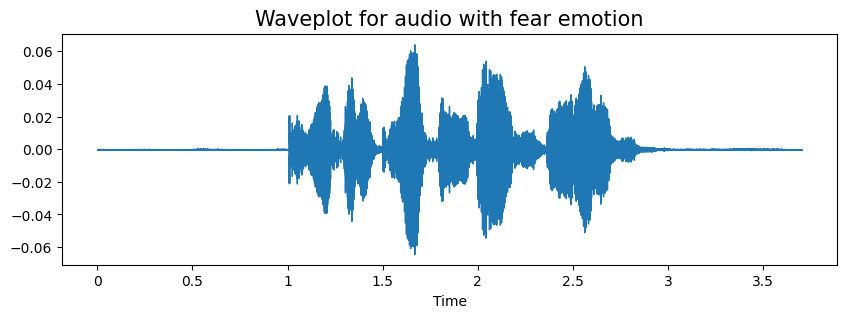

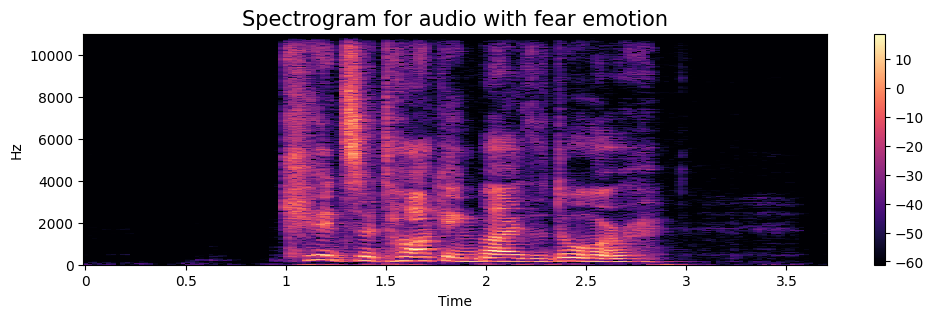

In [15]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

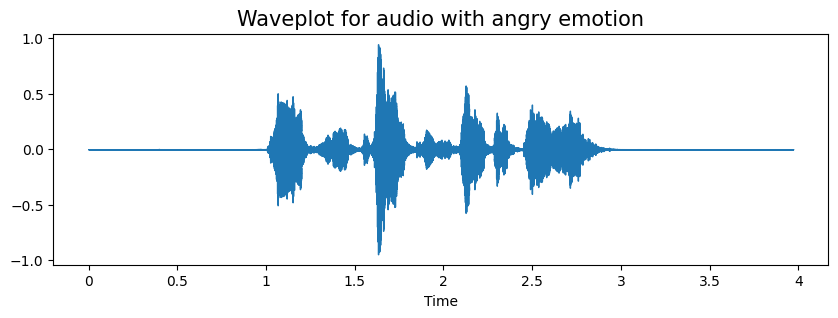

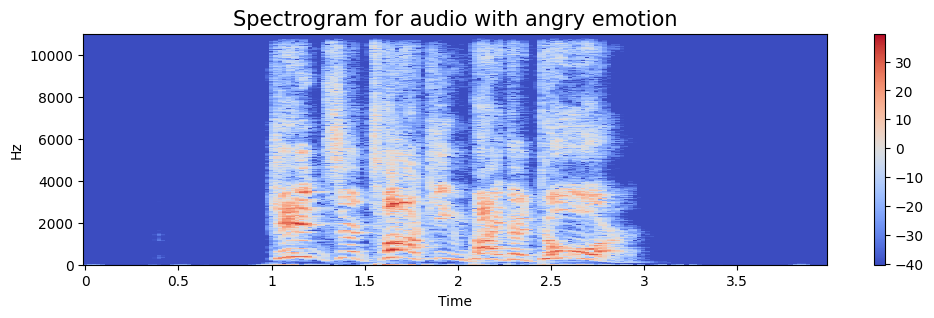

In [16]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

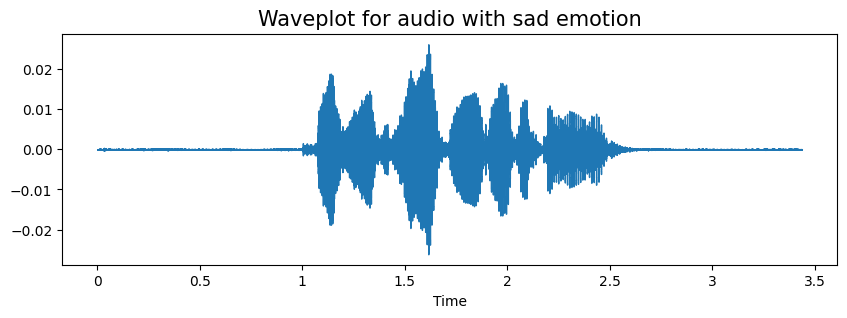

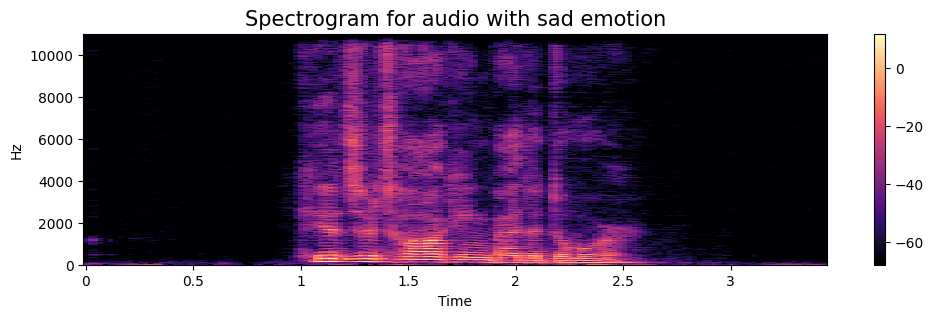

In [17]:

emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

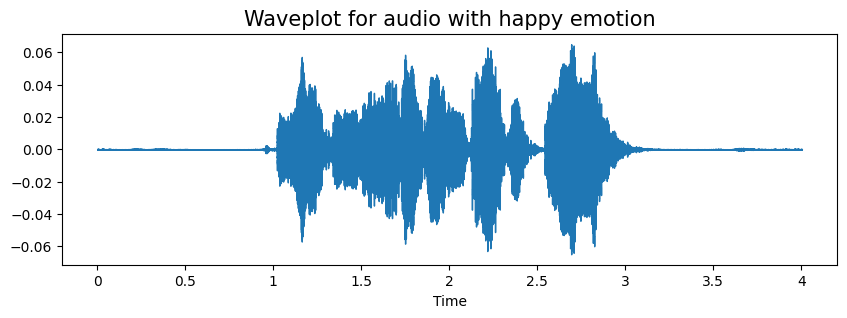

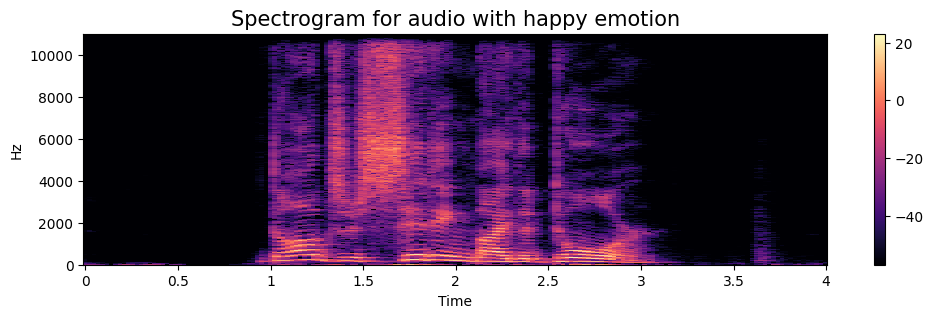

In [18]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

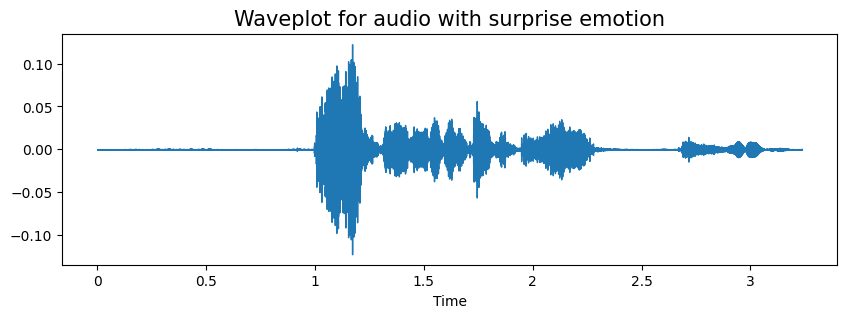

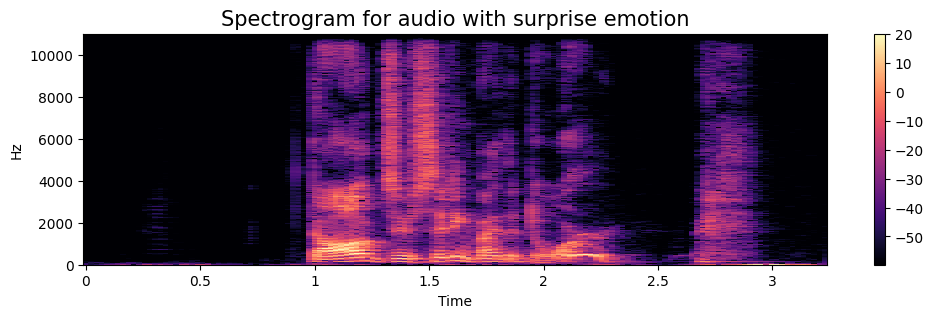

In [19]:
emotion='surprise'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

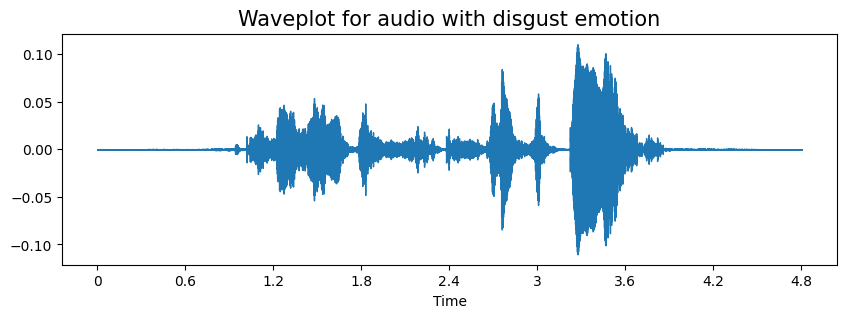

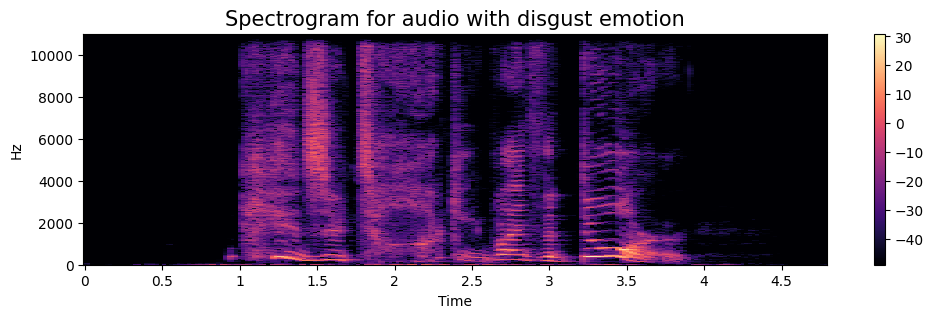

In [20]:
emotion='disgust'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

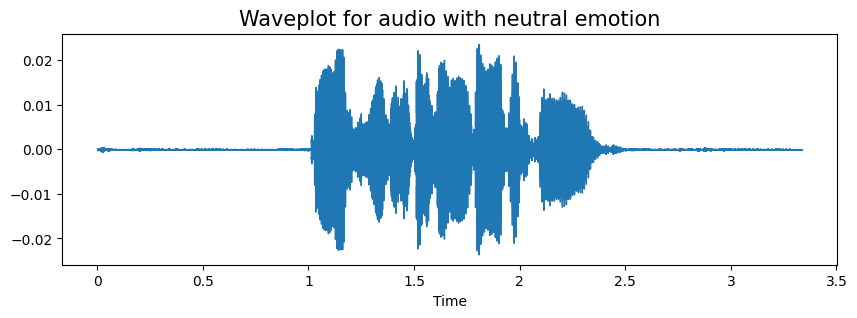

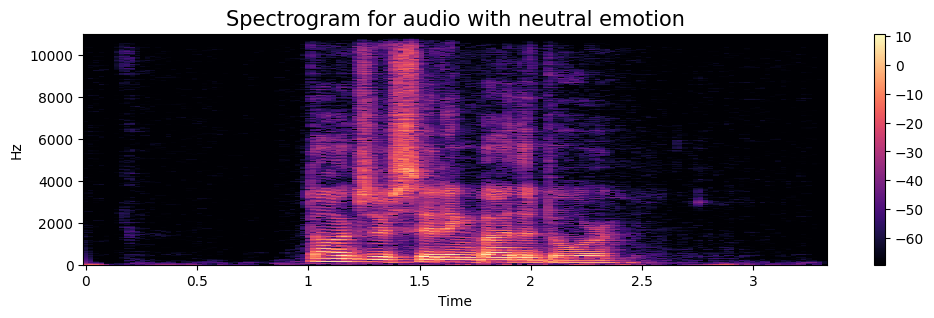

In [21]:
emotion='neutral'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

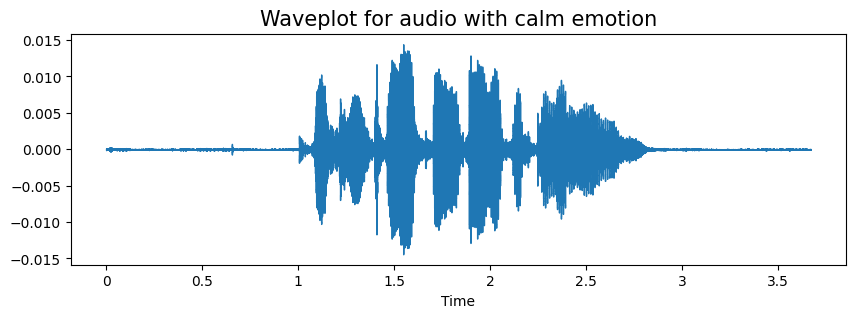

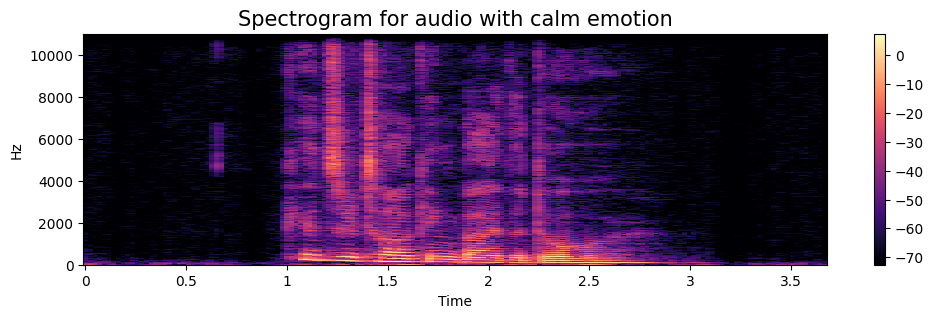

In [22]:
emotion='calm'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

# Data Augmentation

In [23]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data):
    return librosa.effects.time_stretch(data, rate=0.8)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data):
    return librosa.effects.pitch_shift(data, sr=0.8,n_steps=10)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

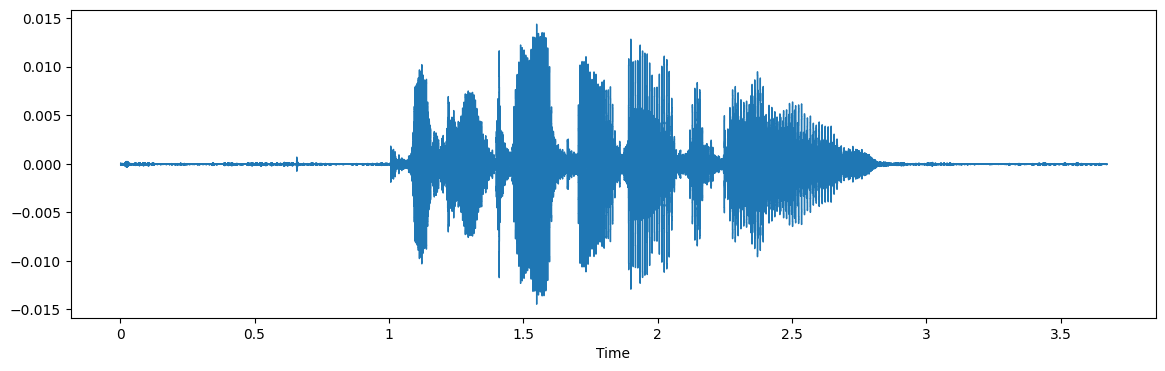

In [24]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

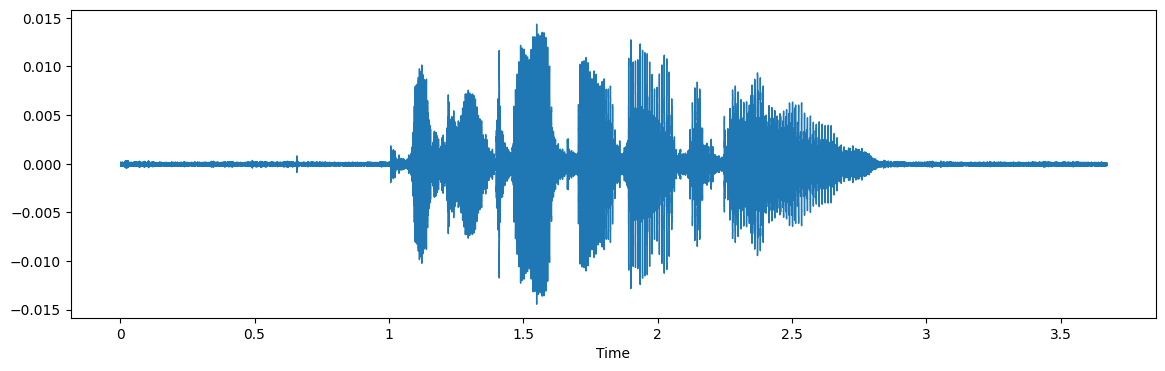

In [25]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

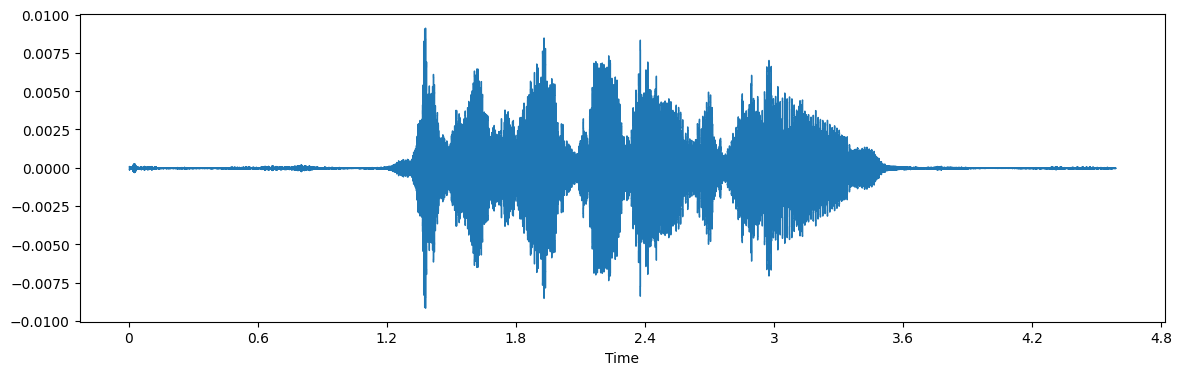

In [26]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)


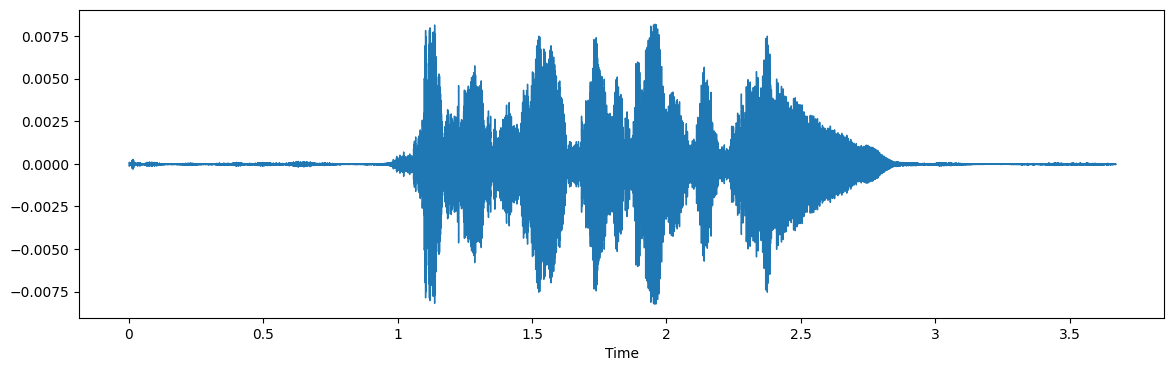

In [27]:
x = pitch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

# Feature Extraction

In [28]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [29]:

X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file .
        Y.append(emotion)

In [30]:
len(X), len(Y), data_path.Path.shape

(14466, 14466, (4822,))

# Saving Features

In [31]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

0         1         2         3         4         5         6  \
0  0.176600  0.576148  0.604915  0.643677  0.653939  0.659375  0.670801   
1  0.233086  0.645003  0.664912  0.705045  0.719294  0.708836  0.652490   
2  0.136068  0.504513  0.549406  0.569656  0.618757  0.652157  0.644536   
3  0.144432  0.503540  0.577656  0.604254  0.570908  0.577800  0.606466   
4  0.220464  0.627732  0.682163  0.714454  0.683667  0.687954  0.688425   

          7         8         9  ...       153       154       155       156  \
0  0.721891  0.773464  0.703678  ...  0.000013  0.000018  0.000019  0.000021   
1  0.673013  0.748192  0.740706  ...  0.000015  0.000020  0.000021  0.000023   
2  0.675069  0.612402  0.488447  ...  0.000063  0.000097  0.000155  0.000082   
3  0.653632  0.652416  0.592111  ...  0.000001  0.000002  0.000003  0.000003   
4  0.650322  0.688078  0.659256  ...  0.000007  0.000007  0.000009  0.000009   

        157       158       159       160           161  Emotions  
0  0.000025  0.000019  0.000017  0.000007  6.438137e-07      calm  
1  0.000027  0.000020  0.000019  0.000009  2.532374e-06      calm  
2  0.000040  0.000012  0.000008  0.000004  5.641153e-07      calm  
3  0.000007  0.000005  0.000003  0.000002  2.247702e-07      calm  
4  0.000012  0.000011  0.000009  0.000008  6.373479e-06      calm  

[5 rows x 163 columns]

In [32]:
Emotions = pd.read_csv('./emotion.csv')
Emotions.head()

0         1         2         3         4         5         6  \
0  0.176600  0.576148  0.604915  0.643677  0.653939  0.659375  0.670801   
1  0.233086  0.645003  0.664912  0.705045  0.719294  0.708836  0.652490   
2  0.136068  0.504513  0.549406  0.569656  0.618757  0.652157  0.644536   
3  0.144432  0.503540  0.577656  0.604254  0.570908  0.577800  0.606466   
4  0.220464  0.627732  0.682163  0.714454  0.683667  0.687954  0.688425   

          7         8         9  ...       153       154       155       156  \
0  0.721891  0.773464  0.703678  ...  0.000013  0.000018  0.000019  0.000021   
1  0.673013  0.748192  0.740706  ...  0.000015  0.000020  0.000021  0.000023   
2  0.675069  0.612402  0.488447  ...  0.000063  0.000097  0.000155  0.000082   
3  0.653632  0.652416  0.592111  ...  0.000001  0.000002  0.000003  0.000003   
4  0.650322  0.688078  0.659256  ...  0.000007  0.000007  0.000009  0.000009   

        157       158       159       160           161  Emotions  
0  0.000025  0.000019  0.000017  0.000007  6.438137e-07      calm  
1  0.000027  0.000020  0.000019  0.000009  2.532374e-06      calm  
2  0.000040  0.000012  0.000008  0.000004  5.641153e-07      calm  
3  0.000007  0.000005  0.000003  0.000002  2.247702e-07      calm  
4  0.000012  0.000011  0.000009  0.000008  6.373479e-06      calm  

[5 rows x 163 columns]

In [33]:
print(Emotions.isna().any())

0           False
1           False
2           False
3           False
4           False
            ...  
158         False
159         False
160         False
161         False
Emotions    False
Length: 163, dtype: bool


In [34]:
np.sum(Emotions.isna())

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


0           0
1           0
2           0
3           0
4           0
           ..
158         0
159         0
160         0
161         0
Emotions    0
Length: 163, dtype: int64

In [35]:
Emotions.shape

(14466, 163)

# Data Preparation

In [36]:
X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [37]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [38]:
print(Y.shape)
X.shape

(14466, 8)


(14466, 162)

In [39]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=101,test_size=0.3, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((10126, 162), (10126, 8), (4340, 162), (4340, 8))

In [40]:
#reshape for lstm
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

In [41]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((10126, 162), (10126, 8), (4340, 162), (4340, 8))

In [42]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

In [48]:
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
model_checkpoint = ModelCheckpoint('best_model1_weights.keras', monitor='val_accuracy', save_best_only=True)
early_stop=EarlyStopping(monitor='val_acc',mode='auto',patience=5,restore_best_weights=True)
lr_reduction=ReduceLROnPlateau(monitor='val_accuracy',patience=5,verbose=1,factor=0.5,min_lr=0.001)

# CNN_LSTM Model

In [49]:
#Reshape for CNN_LSTM MODEL

x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((10126, 162, 1), (10126, 8), (4340, 162, 1), (4340, 8))

In [50]:
model = Sequential()
model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))


model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(128))
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(8, activation='softmax'))

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 162, 1024)           │           6,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 81, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 81, 1024)            │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 81, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 81, 512)             │       2,621,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 41, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 41, 512)             │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 41, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 41, 256)             │         655,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 21, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 21, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 21, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 21, 128)             │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 21, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 21, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 21, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 128)                 │              

 Total params: 3,778,280 (14.41 MB)

 Trainable params: 3,774,696 (14.40 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [51]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [52]:
callbacks = [model_checkpoint,lr_reduction]

history = model.fit(x_traincnn, y_train,
                    validation_data=(x_testcnn, y_test),
                    epochs=100,
                    batch_size=32,
                    callbacks=callbacks)

Epoch 1/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.2153 - loss: 1.9636 - val_accuracy: 0.2426 - val_loss: 1.9693 - learning_rate: 0.0010
Epoch 2/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.3108 - loss: 1.6652 - val_accuracy: 0.3463 - val_loss: 1.5517 - learning_rate: 0.0010
Epoch 3/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.3883 - loss: 1.5169 - val_accuracy: 0.3664 - val_loss: 1.6439 - learning_rate: 0.0010
Epoch 4/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.4566 - loss: 1.4205 - val_accuracy: 0.5945 - val_loss: 1.1129 - learning_rate: 0.0010
Epoch 5/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.5555 - loss: 1.2191 - val_accuracy: 0.6353 - val_loss: 0.9806 - learning_rate: 0.0010
Epoch 6/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.6087 - loss: 1.1061 - val_accuracy: 0.5578 - val_loss: 1.2841 - learning_rate: 0.0010
Epoch 7/100
317/317 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.6

136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7864 - loss: 0.6689
Accuracy of our model on test data :  80.04608154296875 %


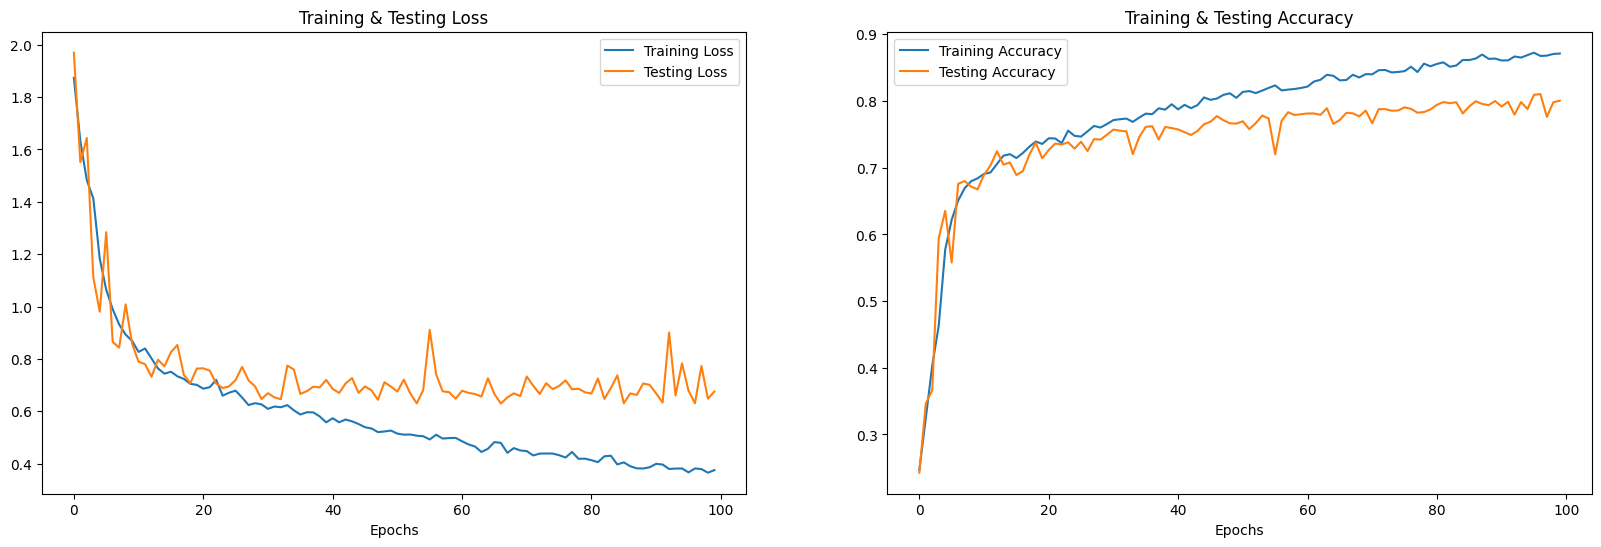

In [53]:
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")
epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [54]:
pred_test = model.predict(x_testcnn)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

# Check for random predictions
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


Predicted Labels Actual Labels
0            happy          fear
1              sad           sad
2             fear          fear
3         surprise      surprise
4            happy      surprise
5          disgust       disgust
6            happy         happy
7             fear          fear
8            angry         angry
9          neutral       neutral

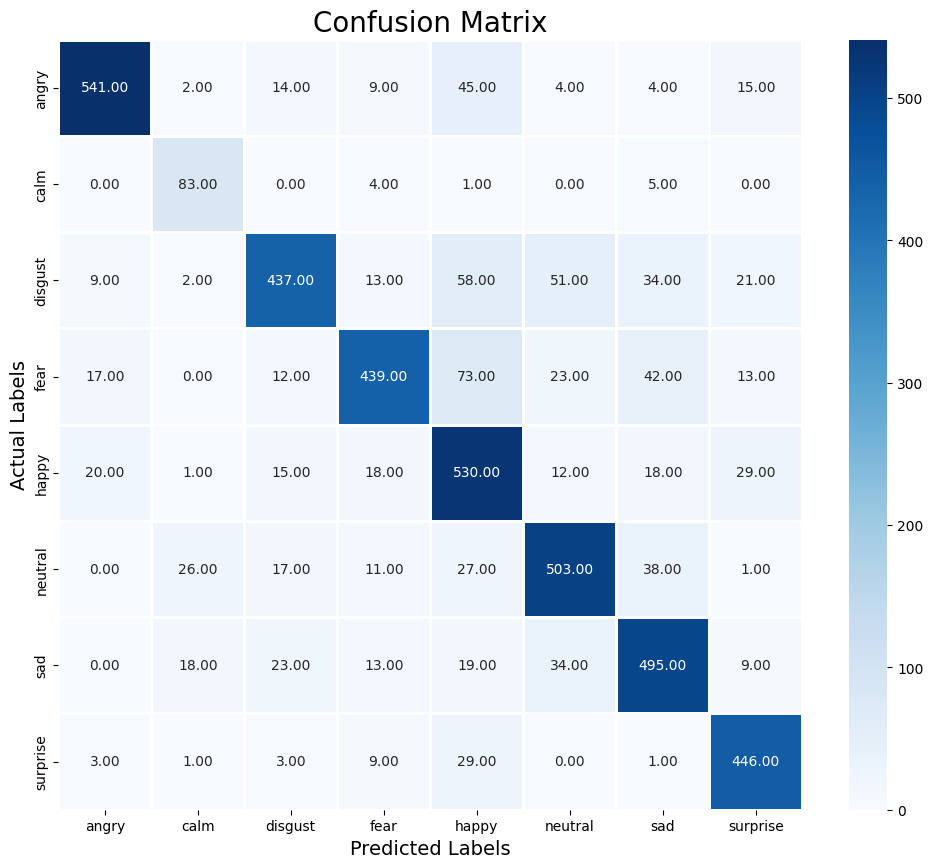

              precision    recall  f1-score   support

       angry       0.92      0.85      0.88       634
        calm       0.62      0.89      0.73        93
     disgust       0.84      0.70      0.76       625
        fear       0.85      0.71      0.77       619
       happy       0.68      0.82      0.74       643
     neutral       0.80      0.81      0.80       623
         sad       0.78      0.81      0.79       611
    surprise       0.84      0.91      0.87       492

    accuracy                           0.80      4340
   macro avg       0.79      0.81      0.80      4340
weighted avg       0.81      0.80      0.80      4340



In [57]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='0.2f')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test, y_pred))